In [1]:
import dataset
import test_training
import importlib
import analysis as an
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch_geometric.loader as geomloader
from trainer import eval
from st_gat import STGAT

In [7]:
import analysis as an
# import importlib
# importlib.reload(an)

bike_data = an.BikeShareData.load(month = '05', year = '2024', width_mins=20, filter = 'average', force_reprocess = True)

Loaded 1002 stations
Preprocessing ridership table
Number of rows with NaN End Station Id: 0


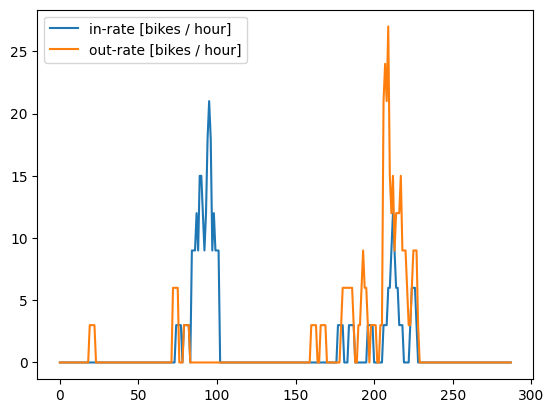

In [9]:
i_station = 5
# plot the in and out rates
times = np.arange(0, 24*60, 5)
plt.plot(bike_data.in_rates[i_station, times], label='in-rate [bikes / hour]')
plt.plot(bike_data.out_rates[i_station, times], label='out-rate [bikes / hour]')
plt.legend()
plt.show()

In [11]:
# load the model file
cfg = test_training.Config.overfit_config()
np.random.seed(cfg.seed)
th.manual_seed(cfg.seed)

model = STGAT(N_nodes= cfg['N_stations'], cfg = cfg, **cfg.__dict__)
model.load_state_dict(th.load(cfg.model_path(epoch = 0)))

data = dataset.BikeGraphDataset(cfg)
train, val, test = data.get_day_splits(shuffle=False)
train_loader = geomloader.DataLoader(train, batch_size=cfg['batch_size'], shuffle=False)

_, _, y_preds, y_demand_preds, y_truths = eval(model, train, train_loader, cfg)

/tmp/ipykernel_8665/2170120985.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load(cfg.model_path(epoch = 0)))


RuntimeError: Error(s) in loading state_dict for STGAT:
	Missing key(s) in state_dict: "gat_layers.0.att_src", "gat_layers.0.att_dst", "gat_layers.0.bias", "gat_layers.0.lin.weight". 
	Unexpected key(s) in state_dict: "gat.att_src", "gat.att_dst", "gat.bias", "gat.lin.weight". 

/tmp/ipykernel_12026/2714381576.py:21: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(y_truth_in_station[times], label=['truth in', 'truth out'])


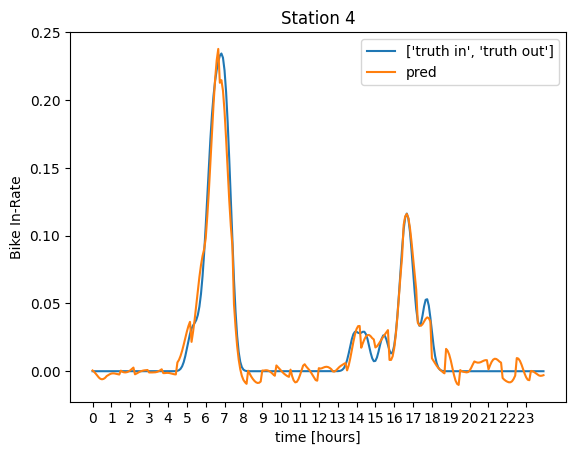

In [ ]:
def reshape_data4viz(y, cfg):
    """
        Reshape the data for visualization.
        Given
        y_truths: (N_batches, batch_size * N_nodes, 2 * N_preds)
        reshape and transform into (N_batches * batch_size, N_nodes, 2) in order to allow concatenating data for contiguous segments (e.g. full days).
    """
    N_batches = y.size(0)
    y_squashed = y.view(N_batches * cfg.batch_size, cfg.N_stations, cfg.N_predictions, 2)
    # swap axes such that the predictions are the axis 1
    y_subsampled = y_squashed[::cfg['N_predictions'], :, :, :].swapaxes(1, 2).reshape(-1, cfg.N_stations, 2)
    return y_subsampled

def plot_station(y_truths, y_preds, i_station, cfg):
    y_truths_reshaped = reshape_data4viz(y_truths,cfg)
    y_preds_reshaped = reshape_data4viz(y_preds,cfg)
    
    y_truth_in_station = y_truths_reshaped[:, i_station, 0]
    y_pred_in_station = y_preds_reshaped[:, i_station, 0]
    times = np.arange(0, 288)
    plt.plot(y_truth_in_station[times], label='truth in')
    plt.plot(y_pred_in_station[times], label='pred')
    plt.legend()
    plt.gca().set(title='Station {}'.format(i_station), xlabel='time [hours]', ylabel='Bike In-Rate')
    plt.xticks(times[::12], times[::12] * cfg['subsample_minutes'] // 60)
    return plt.show()

plot_station(y_truths, y_preds, 4, cfg)

In [ ]:
def plot_station_over_time_reg(y_rate_preds, y_demand_preds, y_truths, i_station, horizon, cfg, times = np.arange(0, 288)):
    """
        Plot the rate predictions, demand predictions and true values for a given station over the given times. Use the `horizon` index into the future, i.e. for horizon = 0, the first prediction is used, etc.
    """
    # y_rate_preds: [num_batches_total × (batch_size * num_nodes) × (num predictions * 2)]

    def extract_horizon(y):
        N_batches = y.size(0)
        y_squashed = y.view(N_batches * cfg.batch_size, cfg.N_stations, cfg.N_predictions, 2)
        ys_future = y_squashed[times, i_station, horizon, :]
        ys_concat = np.concatenate(ys_future, axis = 0)
        return ys_concat

    y_rate_preds_reshaped = extract_horizon(y_rate_preds)
    y_demand_preds_reshaped = extract_horizon(y_demand_preds)
    y_truths_reshaped = extract_horizon(y_truths)

    plt.plot(y_truths_reshaped, label='True Rate')
    plt.plot(y_rate_preds_reshaped, label='Prediction', marker = 'o')
    plt.plot(y_demand_preds_reshaped, label='Demand Prediction', marker = 'x')
    plt.legend()
    horizon_minutes = horizon * cfg.subsample_minutes
    plt.gca().set(title=f'Station {i_station} for horizon {horizon_minutes}', xlabel='time [hours]', ylabel='Bike In-Rate')

In [ ]:
np.linalg.norm(y_preds - y_truths) / np.linalg.norm(y_truths)

np.float32(0.12928247)

[Text(0.5, 1.0, 'Station 66'),
 Text(0.5, 0, 'time [minutes]'),
 Text(0, 0.5, 'Bike In-Rate')]

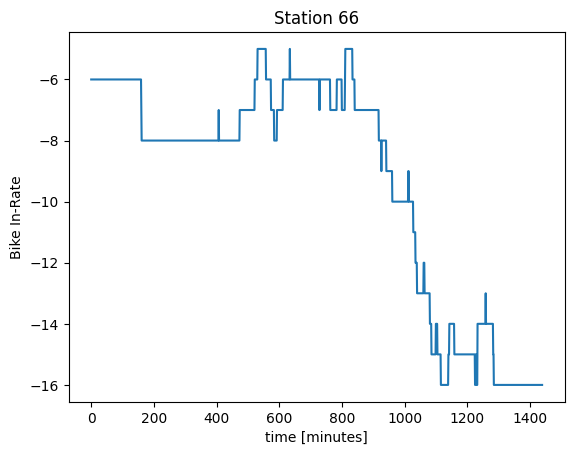

In [ ]:
import analysis as an
bike_data = an.BikeShareData.load(month='05', year='2024')
i_station = 66
month_minutes = 30 * 24 * 60
in_bikes_month = bike_data.in_bikes[i_station, :month_minutes]
out_bikes_month = bike_data.out_bikes[i_station, :month_minutes]
cum_bikes_month = np.cumsum(in_bikes_month) - np.cumsum(out_bikes_month)
plt.plot(cum_bikes_month[24*60: 2*24*60])
plt.gca().set(title='Station {}'.format(i_station), xlabel='time [minutes]', ylabel='Bike In-Rate')


In [ ]:
# compute daily mins and maxes
# reshape the data into single days
# mark the maxes and mins in the plot
num_days = 5
cum_bikes_month = (np.cumsum(in_bikes_month) - np.cumsum(out_bikes_month))[0:24*60*num_days]
reshaped = cum_bikes_month.reshape(-1, 24*60)
daily_maxes = np.max(reshaped, axis=1)
max_inds = np.argmax(reshaped, axis=1)
daily_mins = np.min(reshaped, axis=1)
min_inds = np.argmin(reshaped, axis=1)
plt.plot(cum_bikes_month)
day_starts = np.arange(0, num_days) * 24 * 60
day_ends = np.arange(1, 1+num_days) * 24 * 60
daily_maxes_arr = np.zeros_like(cum_bikes_month)
daily_mins_arr = np.zeros_like(cum_bikes_month)

tolerance = 2

for i, (day_start, day_end) in enumerate(zip(day_starts, day_ends)):
    daily_maxes_arr[day_start:day_end] = daily_maxes[i] - tolerance
    daily_mins_arr[day_start:day_end] = daily_mins[i] + tolerance

plt.plot(daily_maxes_arr, label='daily max')
plt.plot(daily_mins_arr, label='daily min')

plt.legend()
plt.gca().set(title='Station {}'.format(i_station), xlabel='time [minutes]', ylabel='Cumulative Number of Bikes')

NameError: name 'np' is not defined

In [ ]:
at_min_mask = (cum_bikes_month <= daily_mins_arr + 2)
at_max_mask = (cum_bikes_month >= daily_maxes_arr - 2)

In [ ]:
# load the tensorboard logs
import os
import pandas as pd
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator
from config import Config

def load_tensorboard_logs(log_dir):
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()
    tags = event_acc.Tags()['scalars']
    data = {}
    dataframe = pd.DataFrame()
    for tag in tags:
        data[tag] = pd.DataFrame(event_acc.Scalars(tag))
    return data
cfg = Config.overfit_config()

log_dir = cfg['log_dir']

if os.path.exists(log_dir):
    data = load_tensorboard_logs(str(log_dir))
    data
else:
    print(f"Directory {log_dir} does not exist.")
    data = None

In [31]:
event_acc = event_accumulator.EventAccumulator(str(log_dir))
event_acc.Reload()
tags = event_acc.Tags()
list = event_acc.Scalars('Loss/train')

In [41]:
import numpy as np
eval_loss_events = event_acc.Scalars('Loss/eval')
eval_losses = [event.value for event in eval_loss_events]
eval_steps = [event.step for event in eval_loss_events]

min_eval_loss = np.min(eval_losses)
min_eval_loss_step = eval_steps[np.argmin(eval_losses)]
min_eval_loss, min_eval_loss_step

(np.float64(0.06652170419692993), 39)

In [19]:
event_acc.Tags()

{'images': ['Station 4'],
 'audio': [],
 'histograms': [],
 'scalars': ['Loss/train', 'loss', 'MSE', 'RMSE', 'MAE', 'MAPE'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

In [ ]:
from dataset import BikeGraphDataset
import dataset as ds
import analysis as an
from config import Config

cfg = Config.default_config()

data = BikeGraphDataset(cfg)
bike_data = an.BikeShareData.load(month=cfg['month'], year=cfg['year'], force_reprocess=cfg['reload_bike_data'], width_mins = cfg['σ'])

stations = bike_data.stations
stations = stations[stations['lat'].notna()]
adj_matrix = data.adjacency_matrix(stations, min_stations_connected=cfg['min_stations_connected'], max_dst_meters=cfg['max_dst_meters'])



/mnt/vol2/BikeSharePrediction/bikesharepred/dataset.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._data, self.slices, self.N_stations, self.μ, self.σ, self.new2o

In [13]:
import folium, numpy as np
# plot the graph


avg_lat = stations['lat'].mean()
avg_lon = stations['lon'].mean()

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=11)

for idx, row in stations.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=1,
        color='blue',
        fill=True,
        fill_opacity=0.9,
        popup=f"Station {idx}, {row['name']}, Cap: {row['capacity']}"
    ).add_to(m)

# create a colormap like before, for the connections
from branca.colormap import linear

#colormap = linear.YlOrRd_09.scale(min_rides, 100)
#colormap.caption = 'Number of Trips'
#colormap.add_to(m)

# get all indices of the adjacency matrix
indices = np.argwhere(adj_matrix)
for j in range(indices.shape[0]):
    idx = indices[j, :]
    idx_start_station = idx[0]
    idx_end_station = idx[1]

    #start_station = idx[0] - 7000
    #end_station = idx[1] - 7000

    start_station = stations.iloc[idx_start_station]
    end_station = stations.iloc[idx_end_station]

    #color = colormap(row['N'])
    color = 'red'

    folium.PolyLine([(start_station['lat'], start_station['lon']), (end_station['lat'], end_station['lon'])], color=color, weight=1, opacity=0.5).add_to(m)

m